# Model Parameter Hypertuning and PCA Analysis

For this task, we opted for the robust XGBoost model, a powerful gradient boosting algorithm renowned for its efficiency and strong performance on tabular datasets in regression predictive modeling tasks. We also analysed the necessity for Principal Component Analysis (PCA) to reduce the dimensionality of our extensive feature dataset, in order to counter computational and time consumption challenges.

We start by importing the necessary libraries.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from xgb import XGBRegressor

import warnings
warnings.simplefilter(action='ignore')

We also fetch our datasets and separate the target.

In [70]:
df_train = pd.read_csv("twitch_old.csv")
df_test = pd.read_csv("twitch_new.csv")

In [71]:
X_train, y_train = df_train.drop(columns=['rating']), df_train['rating']
X_test, y_test = df_test.drop(columns=['rating']), df_test['rating']

y_train /=100
y_test /=100

### PCA and Explained Variance

To perform PCA, we standardized the features to ensure a consistent scale (mean = 0 and variance = 1). For each fold, we visualized how the explained variation in the initial ~180 features changed as we considered an increasing number of principal components.

Text(0, 0.5, 'Explained Variance')

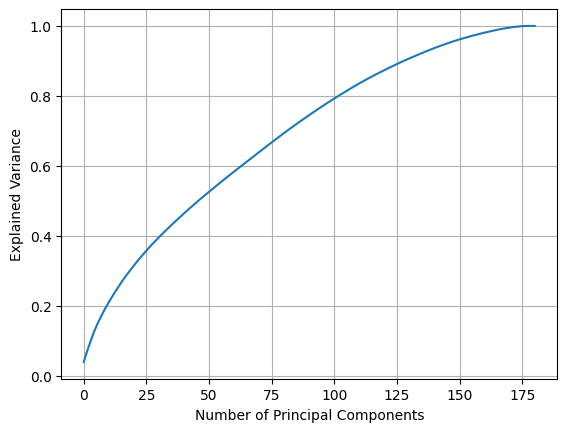

In [39]:
label_encoder = LabelEncoder()

# standardization
scaler = StandardScaler()
scaler.fit(X_train)
norm = scaler.transform(X_train)

pca = PCA()
comp = pca.fit(norm)

# plotting
plt.plot(np.cumsum(comp.explained_variance_ratio_))
    
plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')

### Results and Dimensionality Reduction

The analysis revealed that the first 150 principal components already capture approximately 95% of the dataset's variation. For this project, however, we made the decision to retain the first 130 principal components, which explained around 90% of the variance.

This dimensionality reduction through PCA allows us to work with a bit of a more manageable feature set.

In [40]:
print(np.sum(comp.explained_variance_ratio_[0:150]))
print(np.sum(comp.explained_variance_ratio_[0:130]))

0.9593984069539769
0.9041736700911812


In [72]:
pca = PCA(n_components=130, random_state=42)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [73]:
import pickle
with open("pca.pkl","wb") as file:
    pickle.dump(pca, file)
    file.close()

### Parameter Hypertuning

To ensure that the XGBoost model performs optimally and avoids overfitting, hyperparameter tuning was performed. Various combinations of hyperparameters were explored in a grid search, including the number of estimators, maximum depth of trees, and minimum samples per leaf. Our focus was to minimize the mean squared error (MSE).

In [42]:
best_rmse = np.inf
best = {}

for n_est in range(10, 50, 10):
    for min_child_weight in range(5,30,5):
        for gamma in range(0,3):
            params = {'objective': 'reg:logistic', 'n_estimators': n_est, 'min_child_weight': min_child_weight, 'gamma':gamma/10, 'seed': 123}
            print("Current parameter combination:")
            for parameter, value in params.items():
                print(f"\t{parameter}: {value}")
            print()
            
            model = XGBRegressor(**params)
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, pred))

            if rmse < best_rmse:
                best_rmse = rmse
                best = params
                print("New best parameter combination:")
                print(f"MSE = {best_rmse}")
                for parameter, value in best.items():
                    print(f"\t{parameter}: {value}")
                print()

Current parameter combination:
	objective: reg:logistic
	n_estimators: 10
	min_child_weight: 5
	gamma: 0.0
	seed: 123

New best parameter combination:
MSE = 0.14821240062152177
	objective: reg:logistic
	n_estimators: 10
	min_child_weight: 5
	gamma: 0.0
	seed: 123

Current parameter combination:
	objective: reg:logistic
	n_estimators: 10
	min_child_weight: 5
	gamma: 0.1
	seed: 123

New best parameter combination:
MSE = 0.14815990706035945
	objective: reg:logistic
	n_estimators: 10
	min_child_weight: 5
	gamma: 0.1
	seed: 123

Current parameter combination:
	objective: reg:logistic
	n_estimators: 10
	min_child_weight: 5
	gamma: 0.2
	seed: 123

New best parameter combination:
MSE = 0.14642394519403917
	objective: reg:logistic
	n_estimators: 10
	min_child_weight: 5
	gamma: 0.2
	seed: 123

Current parameter combination:
	objective: reg:logistic
	n_estimators: 10
	min_child_weight: 10
	gamma: 0.0
	seed: 123

Current parameter combination:
	objective: reg:logistic
	n_estimators: 10
	min_child_

In [43]:
best_rmse

0.1415431844403294

In [44]:
best

{'objective': 'reg:logistic',
 'n_estimators': 30,
 'min_child_weight': 20,
 'gamma': 0.2,
 'seed': 123}

In [62]:
model = XGBRegressor(**best)
model.fit(X_train, y_train)
pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
rmse

0.1415431844403294

In [46]:
model.save_model('0001.model')